In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, mapping, shape
from imp import reload
from numpy import mean
from image_utils import search
from numpy.random import randint, choice
import random
import folium
import json
import requests
import os
import cartopy.crs as ccrs
from cartopy import feature
from retrying import retry
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import Circle
import numpy as np
plt.rcParams['figure.figsize'] = (20,20)
%matplotlib inline

# API Search Candidate Selection Protocol
The goal of this notebook is to develop the pathway from a set of single-measurement points to a set of cropped PlanetScope imagery for a given date band. 

## Extract 2017 Measurement Locations

In [3]:
snowdata = pd.read_csv("../data/snow_summary_all_2009_2017_locs.csv", 
                       parse_dates = ["snow_appearance_date", "snow_disappearance_date", 
                                      "date_min", "date_max"])
snowdata = snowdata[snowdata.year >= 2017]
snowdata['geometry'] = [Point(xy) for xy in zip(snowdata.longitude, snowdata.latitude)]
snowdata = gpd.GeoDataFrame(snowdata)
snowdata.crs = {'init' : 'epsg:4326'}
snowdata.head()

,Study,Location,date_min,date_max,temp_min,temp_max,hobo,ibutton,year,calibration_temp,snow_appearance_date,snow_disappearance_date,snow_cover_duration,minimum_soil_temp,longitude,latitude,geometry
1216,JHRL,AB08-S1,2016-09-09 13:00:00,2017-06-20 10:04:00,-1.341,50.180,True,False,2017,0.0,2016-11-17,2017-04-06,132,-1.341,-121.53724,46.92012,POINT (-121.53724 46.92012)
1220,JHRL,AB08-S2,2016-09-09 13:00:00,2017-06-20 10:14:00,-2.261,25.805,True,False,2017,0.0,2016-11-17,2017-04-14,137,-2.261,-121.53725,46.92006,POINT (-121.53725 46.92006)
1224,JHRL,AB08-S3,2016-09-09 13:00:00,2017-06-20 10:10:00,-0.774,31.268,True,False,2017,0.0,2016-11-28,2017-04-12,136,-0.774,-121.53726,46.92000,POINT (-121.53726 46.92)
1228,JHRL,AB08-S4,2016-09-09 13:00:00,2017-06-20 10:14:00,-2.377,26.585,True,False,2017,0.0,2016-11-17,2017-04-14,136,-2.377,-121.53725,46.91993,POINT (-121.53725 46.91993)
1232,JHRL,AB08-S5,2016-09-09 13:00:00,2017-06-20 10:26:00,-0.549,32.291,True,False,2017,0.0,2016-11-28,2017-04-11,135,-0.549,-121.53727,46.91986,POINT (-121.53727 46.91986)


In [4]:
locations = snowdata.dropna(subset=["longitude", 'latitude']).drop_duplicates("Location")
center = (mean(locations.latitude), mean(locations.longitude))
m = folium.Map(center)
folium.GeoJson(locations.geometry.to_json()).add_to(m)
m

## Add bounding boxes

In [6]:
boxes = locations[['Location', 'geometry']].copy()
boxes.geometry = [g.buffer(0.005, cap_style=3) for g in boxes.geometry]
m = folium.Map(center)
folium.GeoJson(boxes.geometry).add_to(m)
m

NameError: name 'dates' is not defined

## Search

In [7]:
reload(search)
dates = locations[['Location', "snow_appearance_date", "snow_disappearance_date"]]
searcher = search.Search(boxes, dates, dry=False,
                         key='Location', start_col='snow_appearance_date',
                         end_col="snow_disappearance_date")
results = searcher.query()

Querying Planet API:   0%|          | 0/83 [00:00<?, ?searches/s]

83


InvalidAPIKey: No API key provided

## Parse Results

In [157]:
for group in results.groupby('loc_id'):
    print(group[0], len(group[1]))

1228 17
1236 14
1473 24
1590 20
1684 14
1749 86
1784 8
1817 5
2011 56
2021 66


### Plot For a single Location the Scenes

In [250]:
loc = 2011

m = folium.Map(center)
folium.GeoJson(boxes.geometry).add_to(m)
for geom in results[results.loc_id == loc].geometry:
    folium.GeoJson(geom, style_function = lambda _: {'color' : "tomato", 'opacity':0.01}).add_to(m)
folium.GeoJson(mapping(boxes.loc[loc].geometry), style_function=lambda _: {'color' : 'black'}).add_to(m)
m

### Which scenes have low cloudiness? <small> this might not be useful.</small>
Pick one at random.

In [174]:
print("Location {l}".format(l=loc))

img  = choice([x.id for i, x in results[results.loc_id == loc].iterrows() if x['properties']['cloud_cover'] < 1])
print("Image ", img)
Image(url="https://api.planet.com/data/v1/item-types/PSScene4Band/items/{id}/thumb?width=800".format(id=img))


Location 2011
Image  20161022_181256_0e0e


### Download cropped version

In [175]:
CLIP_API_URL = "https://api.planet.com/compute/ops/clips/v1/"
PL_API_KEY = os.environ["PL_API_KEY"]

print(json.dumps(mapping(boxes.loc[loc].geometry)))


{"coordinates": [[[-121.69339, 46.89589], [-121.69339, 46.885889999999996], [-121.70338999999998, 46.885889999999996], [-121.70338999999998, 46.89589], [-121.69339, 46.89589]]], "type": "Polygon"}


In [176]:
@retry(wait_fixed=5000)
def check_clip_op(id):
    r = requests.get("{_base}/{id}".format(_base = CLIP_API_URL, id=id), auth=(PL_API_KEY, ""))
    if r.json()['state'] != "succeeded":
        raise Exception("Not Yet")
        print("...waiting")
    else:
        print("response found.")
        return(r.json())

In [177]:
payload = {
    "aoi" : mapping(boxes.loc[loc].geometry),
    "targets" : [{
        "item_id" : img, 
        "item_type" : "PSScene4Band", 
        "asset_type" : 'analytic'
    }]
}
r = requests.post(CLIP_API_URL, auth=(PL_API_KEY, ""), json=payload)

check_clip_op(r.json()['id'])

response found.


{'_links': {'_self': 'https://api.planet.com/compute/ops/clips/v1/e0bece8c-3869-4da9-a9e9-a9dacbe48d6d',
  'results': ['https://api.planet.com/data/v1/download?token=eyJhbGciOiJIUzUxMiIsInR5cCI6IkpXVCJ9.eyJleHAiOjE1MTcyOTc3NDEsInN1YiI6IjlhK2NyWWNBTjA3Z2lKSDBtZ0NZaWJvOXMxNFNsVFpBdWd3VkU2U2d6NnZFRHZGZjZGaUNadzMyOVVQUStKS1pnZHR3aVc0eC9odnk0WGNKM2F6SkRnPT0iLCJ0b2tlbl90eXBlIjoiZG93bmxvYWQtYXNzZXQtc3RhY2siLCJhb2kiOiJ7XCJ0eXBlXCI6IFwiUG9seWdvblwiLCBcImNvb3JkaW5hdGVzXCI6IFtbWy0xMjEuNjkzMzksIDQ2Ljg5NTg5XSwgWy0xMjEuNjkzMzksIDQ2Ljg4NTg4OTk5OTk5OTk5Nl0sIFstMTIxLjcwMzM4OTk5OTk5OTk4LCA0Ni44ODU4ODk5OTk5OTk5OTZdLCBbLTEyMS43MDMzODk5OTk5OTk5OCwgNDYuODk1ODldLCBbLTEyMS42OTMzOSwgNDYuODk1ODldXV19IiwiYXNzZXRzIjpbeyJpdGVtX3R5cGUiOiJQU1NjZW5lNEJhbmQiLCJhc3NldF90eXBlIjoiYW5hbHl0aWMiLCJpdGVtX2lkIjoiMjAxNjEwMjJfMTgxMjU2XzBlMGUifV0sInVybCI6Imh0dHBzOi8vcGxhbmV0LXBsYXRmb3JtLWNvbXB1dGVkLWFzc2V0cy5zMy11cy13ZXN0LTIuYW1hem9uYXdzLmNvbS9lMGJlY2U4Yy0zODY5LTRkYTktYTllOS1hOWRhY2JlNDhkNmQtY2xpcHMuemlwP1gtQW16LUFsZ29yaXRobT1BV

In [178]:
planet_image = check_clip_op(r.json()['id'])

response found.


In [179]:
def download_file(url, dest):
    local_filename = dest
    # NOTE the stream=True parameter
    r = requests.get(url, stream=True, auth=(PL_API_KEY, ""))
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    return local_filename


In [181]:
url_template = "/Volumes/wrangell-st-elias/research/planet/{id}_download.zip"
download_url = planet_image['_links']['results'][0]
local_url = url_template.format(id=r.json()['id'])
download_file(download_url, local_url)


'/Volumes/wrangell-st-elias/research/planet/e0bece8c-3869-4da9-a9e9-a9dacbe48d6d_download.zip'

In [182]:
! unzip '/Volumes/wrangell-st-elias/research/planet/e0bece8c-3869-4da9-a9e9-a9dacbe48d6d_download.zip'

Archive:  /Volumes/wrangell-st-elias/research/planet/e0bece8c-3869-4da9-a9e9-a9dacbe48d6d_download.zip
 extracting: 20161022_181256_0e0e_3B_AnalyticMS_clip.tif  
 extracting: 20161022_181256_0e0e_3B_AnalyticMS_metadata_clip.xml  
 extracting: 20161022_181256_0e0e_3B_AnalyticMS_DN_udm_clip.tif  


In [185]:
!ls

20161022_181256_0e0e_3B_AnalyticMS_DN_udm_clip.tif
20161022_181256_0e0e_3B_AnalyticMS_clip.tif
20161022_181256_0e0e_3B_AnalyticMS_metadata_clip.xml
Untitled1.ipynb
Untitled3.ipynb
image_utils
locations.html
pipeline-all.ipynb
search-test.ipynb
sensor_bbox.json


## Plot Resulting Image

In [224]:
import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image
from skimage import img_as_ubyte, exposure

In [232]:
f = rasterio.open("/Volumes/wrangell-st-elias/research/planet/20161022_181256_0e0e_3B_AnalyticMS_clip.tif")


In [205]:
img_crs = f.crs['init'].split(':')[1]

/Users/tony/miniconda3/envs/imageprocess/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2862: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/tony/miniconda3/envs/imageprocess/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/tony/miniconda3/envs/imageprocess/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


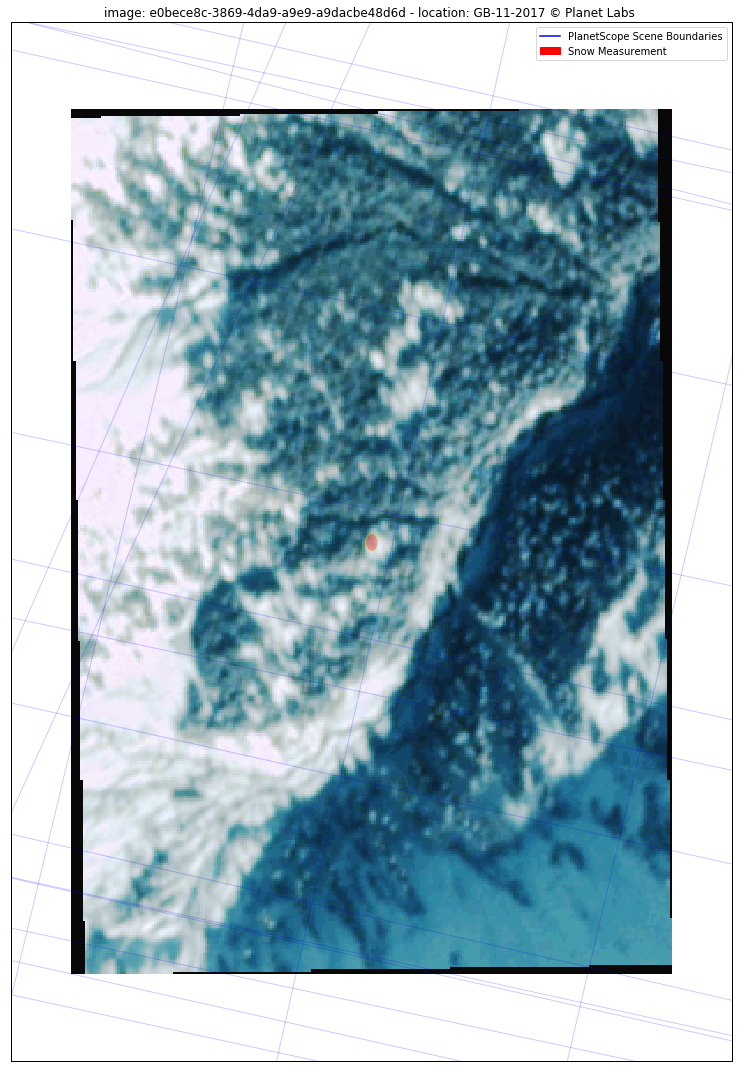

In [353]:
src=f
xmin = src.transform[0]
xmax = src.transform[0] + src.transform[1]*src.width
ymin = src.transform[3] + src.transform[5]*src.height
ymax = src.transform[3]
plt.rcParams['figure.figsize'] = (15,15)
crs = ccrs.epsg(img_crs)
ax = plt.axes(projection=ccrs.epsg(img_crs))
red = f.read(3)
green = f.read(2)
blue = f.read(1)

imgdata = img_as_ubyte(np.stack([red, green, blue], axis=2))
bounds = boxes.loc[loc].geometry.bounds
buffer = 0.001
ax.set_extent((bounds[0]-buffer, bounds[2]+buffer, bounds[1]-buffer, bounds[3]+buffer), crs=ccrs.PlateCarree())
imgdata = exposure.equalize_hist(imgdata)
plt.imshow(imgdata, origin='upper', extent=[xmin, xmax, ymin, ymax], transform=crs, interpolation='nearest')
ax.add_geometries([locations.loc[loc].geometry.buffer(0.0001)], crs=ccrs.PlateCarree(), facecolor="red", alpha=0.3, edgecolor='yellow')
plt.title("image: {img_id} - location: {loc_id} © Planet Labs ".format(img_id=r.json()['id'], loc_id=locations.loc[loc].Location))

for geom in results[results.loc_id == loc].geometry:
    ax.add_geometries([shape(geom)], crs=ccrs.PlateCarree(), alpha=0.2, facecolor='none', edgecolor='blue')

blue_line = mlines.Line2D([], [], color='blue',
                          markersize=15, label='PlanetScope Scene Boundaries')
circle = Circle([],radius=5, color='red', fill=True, label="Snow Measurement")
plt.legend(handles=[blue_line, circle])
plt.tight_layout()